In [ ]:
# Remeber to activate the virtual environment first by typing the following in the terminal
# py -3 -m venv .venv
# .venv\scripts\activate

# open a dialog box to insert the file we are going to process
import tkinter as tk
from tkinter import ttk
from tkinter import filedialog as fd
from tkinter.messagebox import showinfo

# Importing packages for data loading
import pandas as pd

# Importing all the packages for plotting
# importing seabord just to set the color palette
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

# Importing numpy for manipulatring the data
import numpy as np

# Importing distance package for calculating distances 
from scipy.spatial import distance

#For debugging
# Contains five lanes changes (including hard shoulder emergency)
#filename = 'C:/Users/AndreaCastegnaro/AppData/LocalLow/MXTreality/driving-sim-data-collection/MotorWaySimulation/Data/driving-sim-data-collection_DSMAnalyticsSystem_202201281610_Run_1.csv';
# Contains four lanes changes (including hard shoulder emergency)
filename = 'C:/Users/AndreaCastegnaro/AppData/LocalLow/MXTreality/driving-sim-demo/MotorWaySimulation/Data/driving-sim-demo_DSMAnalyticsSystem_202202041733_Run_0.csv';

# Opens a dialog box 
#filename = fd.askopenfilename(title='Open a DSM generated file',defaultextension='.csv',initialdir="%appdata%")


In [ ]:
dsmData = pd.read_csv(filename);
# Dropping the last column as the csv has always a trailing comma
dsmData = dsmData.iloc[:,:-1];
# Setting the time as a current index for the data
#dsmData.head()

del filename

In [ ]:
# let s convert the time in milliseconds to second  
dsmData['time_s'] = dsmData.time_ms /1000
dsmData.set_index('time_s',inplace=True)

# let s calculate the moving average using a time window of 2.5 s. Data is captured every 50ms so we need to average across 50 data points
# This will make the graph smoother
dsmData['SMA_50'] = dsmData.EgoSpeed.rolling(50, min_periods=1).mean()

In [ ]:
#Creating general variables

# Resetting the previous saved configuration
sns.reset_defaults()
# Increase the figure size
#sns.set_theme(style="whitegrid")
sns.set(style='white')

# Increase the sharpness of the display
plt.rcParams['figure.dpi']  = 300
serif_font = {'fontname':'serif'}
font_size = {'size':12}
title_size = {'size':14}

# let's also take the colors from the color palette
colPalette = sns.color_palette('Dark2')

In [ ]:
fig_size = {'figsize':(9,3)}

# create a new figure
fig, ax = plt.subplots(**fig_size);

# plotting the full time series
# plt.plot(dsmData.index,dsmData.loc[:,"EgoSpeed"])
plt.plot(dsmData.index ,dsmData.SMA_50, c=colPalette[2])
# plotting an area where the speed is over the limit
plt.axhline(y=70, color=colPalette[3],linestyle=(5, (4, 3)), alpha = 0.7, lw = 1.2)

# setting the labels and an horizontal grid 
plt.grid(axis='y', alpha = 0.5)
plt.xlabel('Time (s)',**font_size, **serif_font)
plt.ylabel('Speed (mph)',**font_size, **serif_font)
plt.xticks(**font_size, **serif_font)
plt.yticks(**font_size, **serif_font)
plt.title("'Ego' vehicle speed", **title_size,**serif_font)

# Removing top and right border
sns.despine();
plt.savefig("Results/EgoSpeedOverTime.png", bbox_inches="tight")

# Showing the plot
plt.show()

del fig, ax

In [ ]:
# Calculating the amount of time spent in each of the lane
# We need to do some filtering. For each of the LaneID column we need to extract the last number after the last '_' character

# Let's create a function that will operate on the elements of the column
def extractLaneNumber(laneRoadID):
    if not pd.isna(laneRoadID):
        laneRoadIDpartitions = laneRoadID.split('_')
        extractedValue  = laneRoadIDpartitions[len(laneRoadIDpartitions)-1]
        fourLanesRoad = ['116','392']
        # In this way all the lanes will have the same index for the right most lane (for taking over)
        if not any(l in laneRoadID for l in fourLanesRoad):
            extractedInt = int(extractedValue) + 1
            extractedValue = str(extractedInt)
    else:
        extractedValue = str(-1)
    return extractedValue

# Let's create a new column containing only the lane information for the egovehicle
# First we duplicate the ego vehicle full lane
dsmData['ExtractedLaneNumber'] = dsmData['EgoLaneID']

# Second we explicity set the type for that string
dsmData['ExtractedLaneNumber'] = dsmData['ExtractedLaneNumber'].astype("string")

# Third we apply a transformation to this column by using the function we defined at the beginning of the block
dsmData['ExtractedLaneNumber'] = dsmData['ExtractedLaneNumber'].transform(extractLaneNumber)

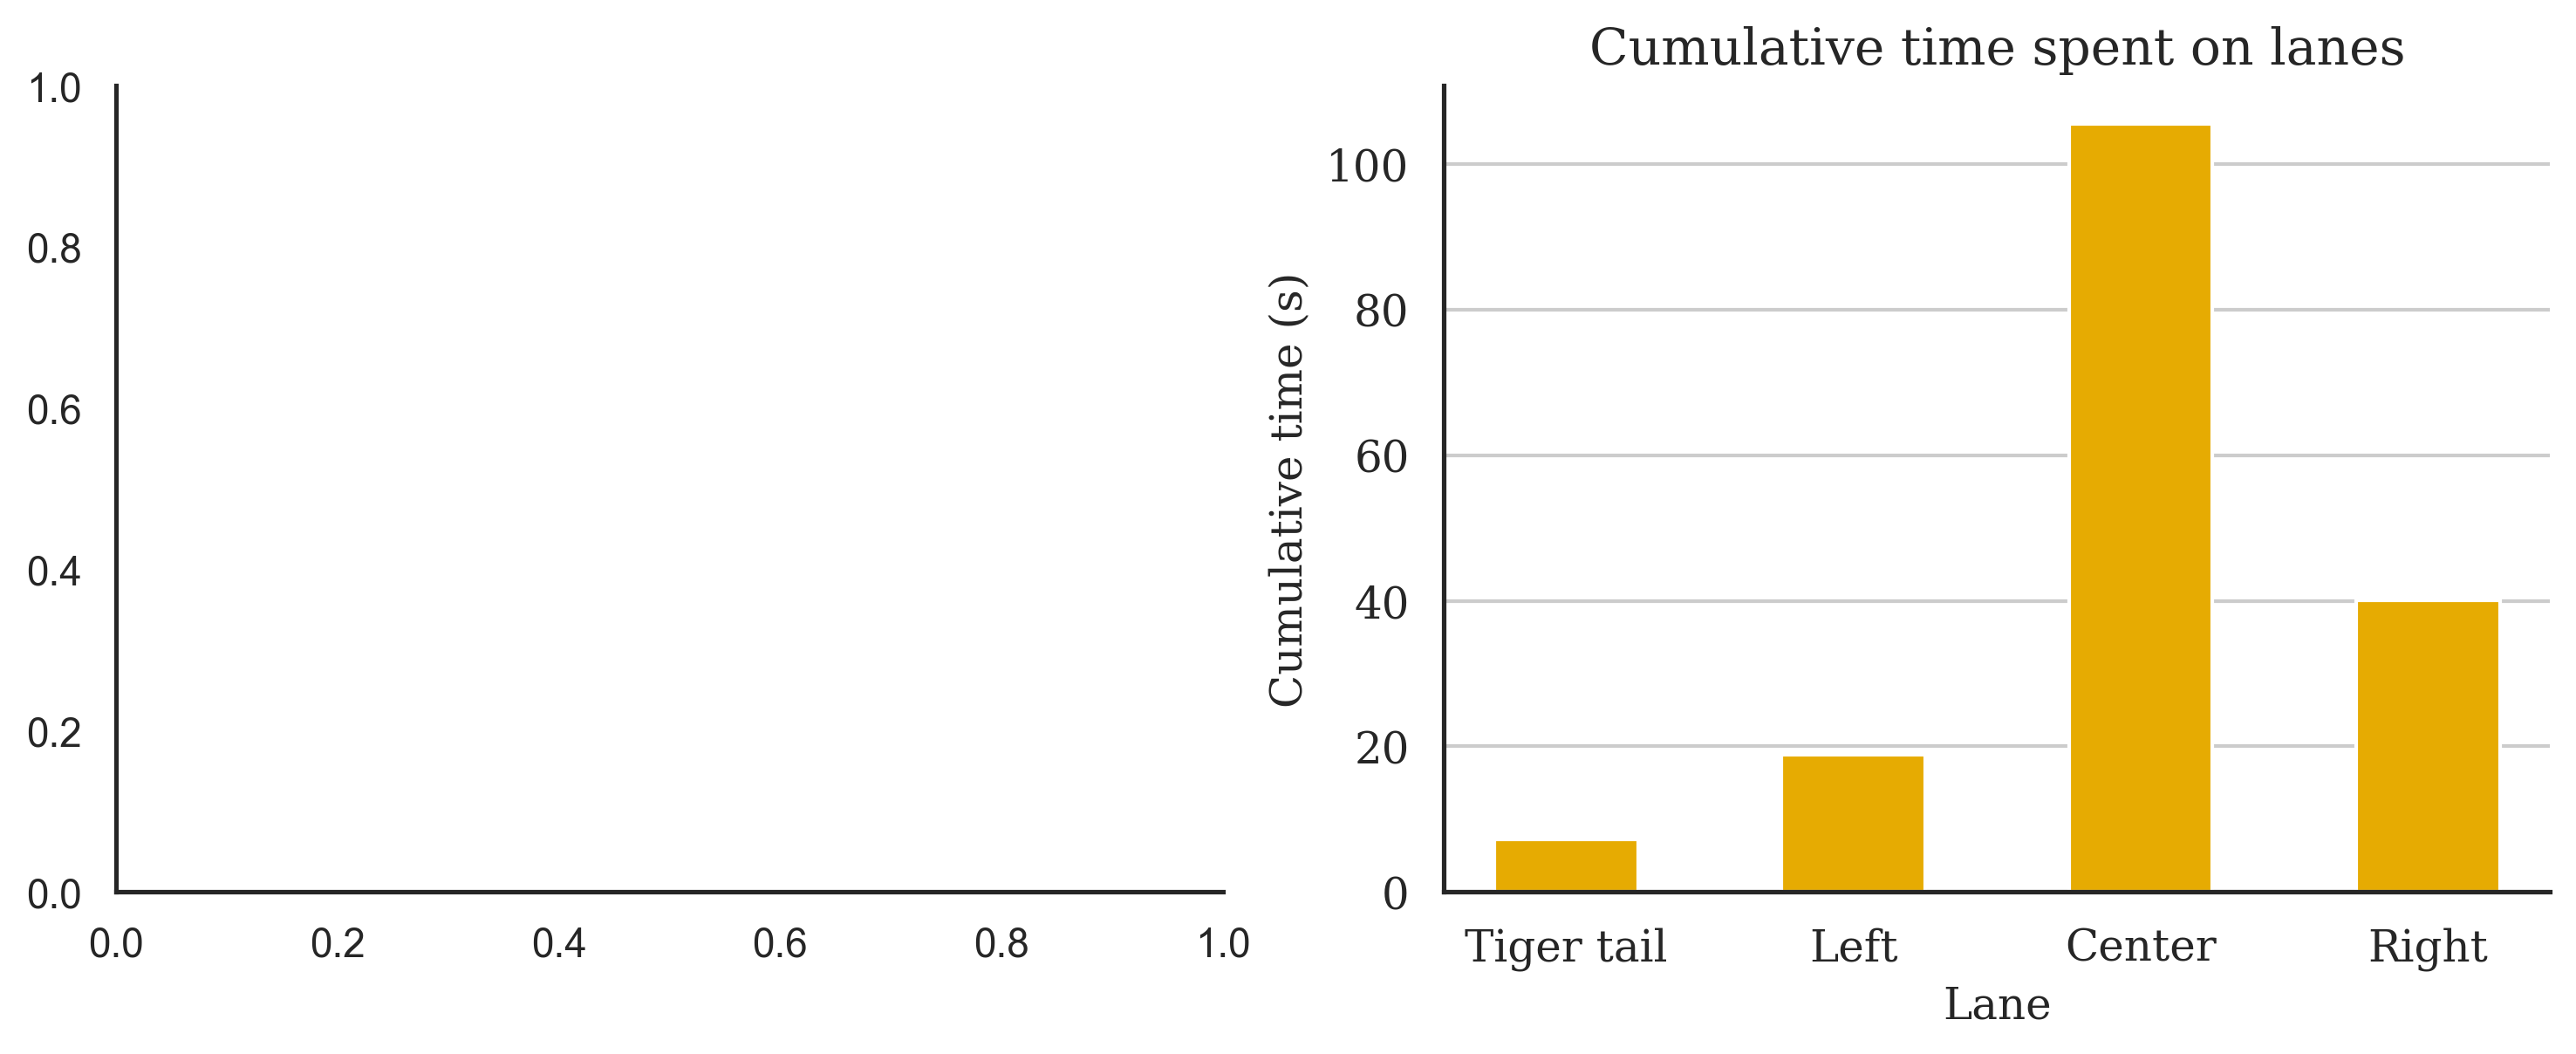

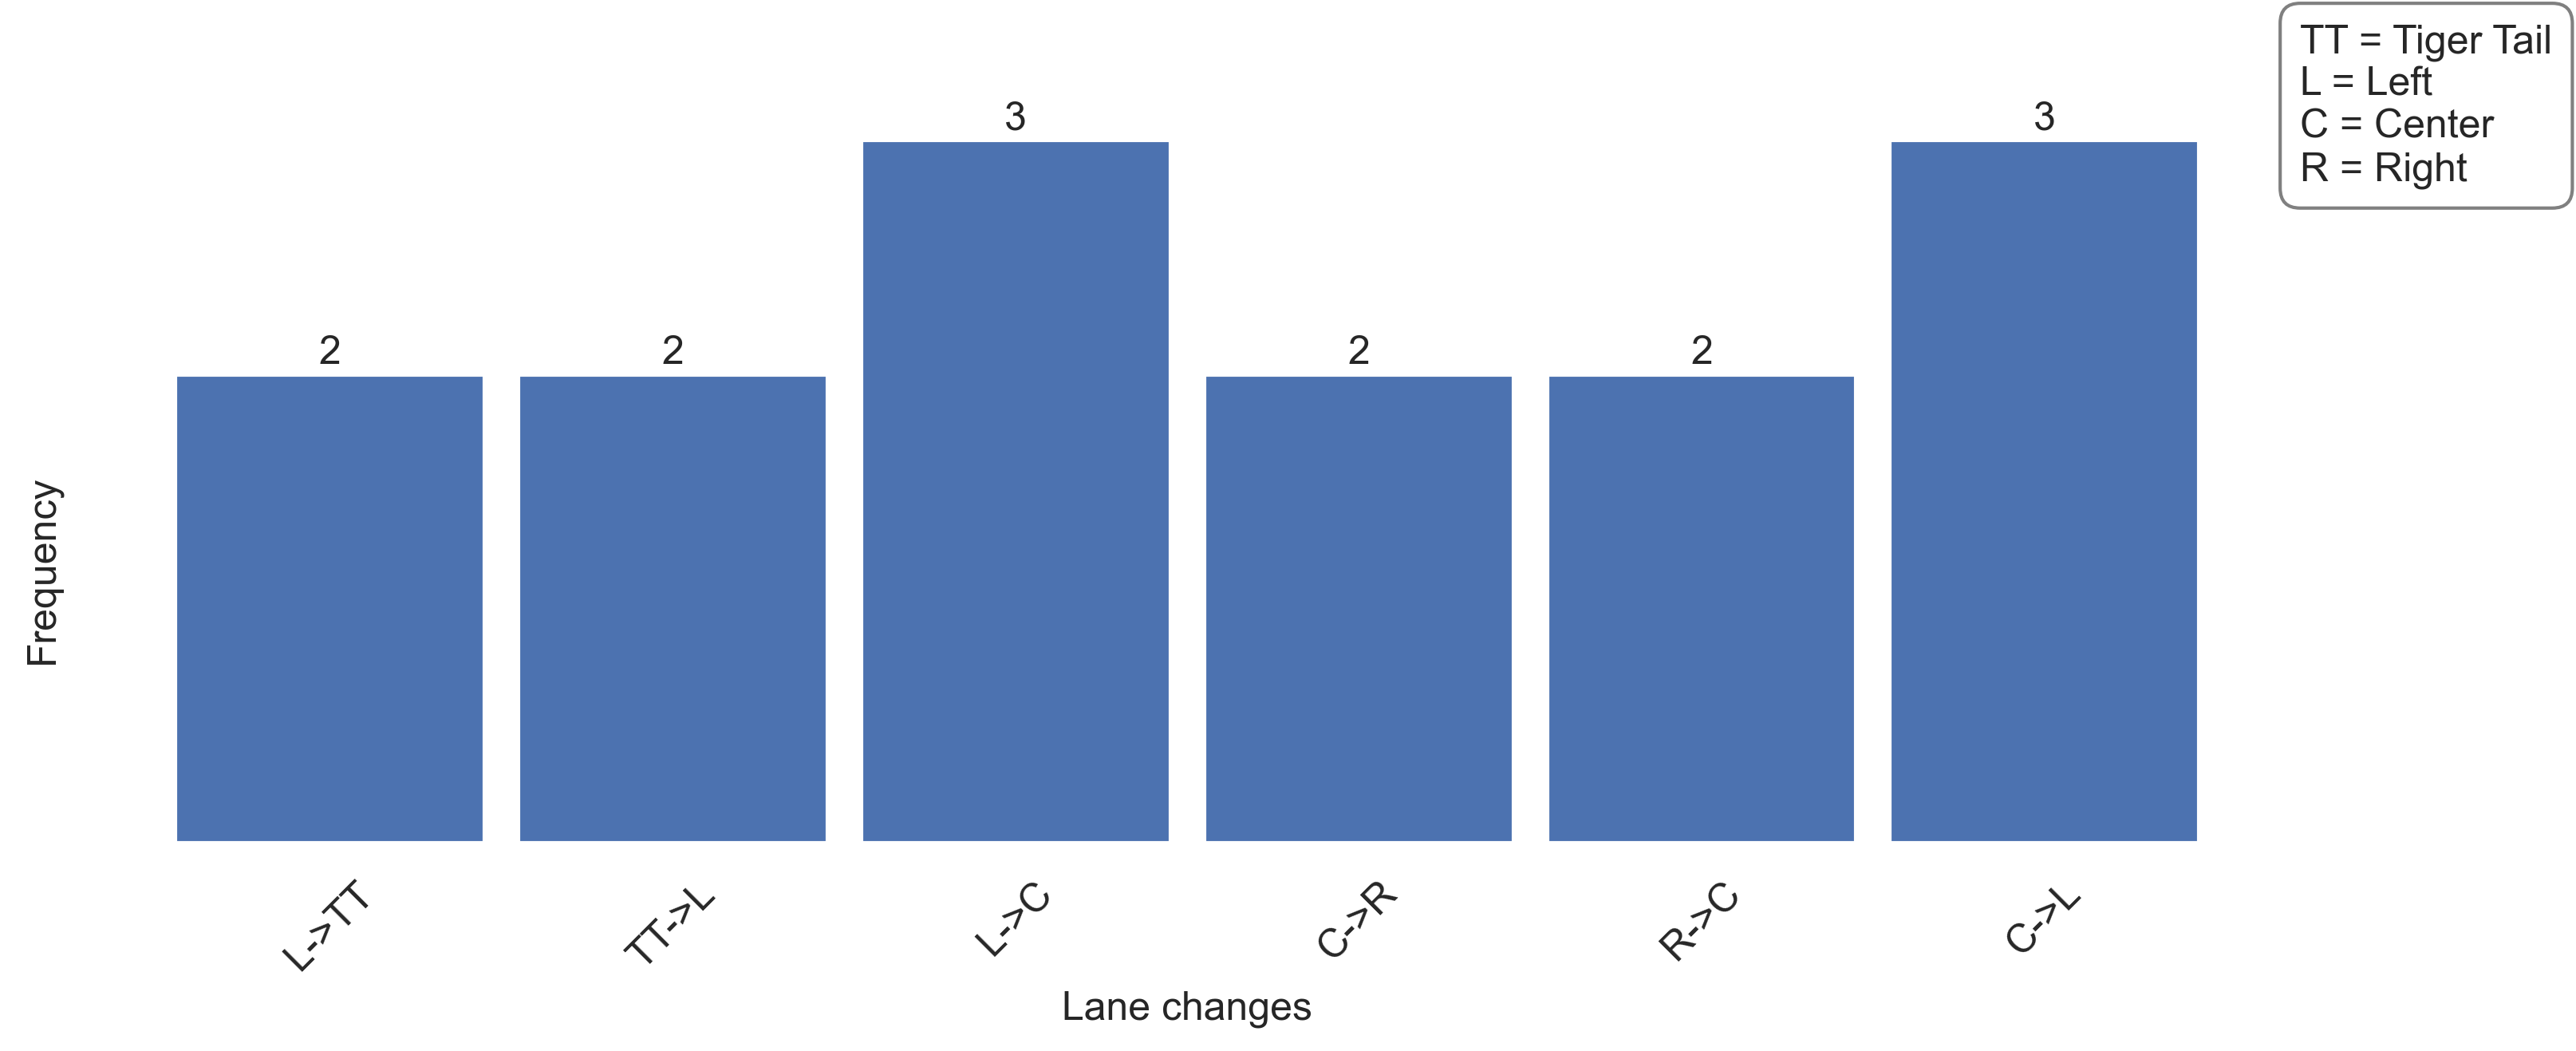

In [21]:
fig_size = {'figsize':(12,4)}

# Let s get unique lane ids
uniqueLanes = pd.unique(dsmData.ExtractedLaneNumber)

# get the number of unique extracted lanes:
# it should be 4 if we did not go into an hardshoulder lane 
# it should be 5 if the user went also on the hardshoulder lane (emergency)
differentDetectedLanes = len(uniqueLanes)

# Let's count the occurrence of that lane for the ego vehicle
# We are going to reset the index for this operation
if not dsmData.index.isnull:
    dsmData.reset_index(inplace=True)
secsPerLane = dsmData.groupby('ExtractedLaneNumber')['time_ms'].count()
# print(secsPerLane)

# Trasforming the count in seconds according to the granularityu of the data
secsPerLane = secsPerLane*0.05
# print(secsPerLane)

# create a new figure
fig, ax = plt.subplots(1,2,**fig_size);

# Unfortunately this does not work as counting the time is not enough if we can't multiply each count by 0.05 (time interval between data points)
#plt.hist(dsmData.ExtractedLaneNumber)

if differentDetectedLanes == 5:
    plt.bar([-1, 0, 1, 2, 3], secsPerLane, width=0.5, color = colPalette[5])
elif differentDetectedLanes == 4:
    plt.bar([0, 1, 2, 3], secsPerLane, width=0.5, color = colPalette[5])
else:
    plt.bar([1, 2, 3], secsPerLane, width=0.5, color = colPalette[5])

# setting the labels and an horizontal grid 
plt.grid(axis='y')
plt.xlabel('Lane',**font_size, **serif_font)
plt.ylabel('Cumulative time (s)',**font_size,**serif_font)
plt.xticks(**font_size,**serif_font)
plt.yticks(**font_size,**serif_font)

if differentDetectedLanes == 5:
    plt.xticks([-1, 0, 1, 2, 3], ['Hard Shoulder', 'Tiger tail', 'Left', 'Center', 'Right'])
elif differentDetectedLanes == 4:
    plt.xticks([0, 1, 2, 3], ['Tiger tail', 'Left', 'Center', 'Right'])
else:
    plt.xticks([1, 2, 3], ['Left', 'Center', 'Right'])

plt.title('Cumulative time spent on lanes', **title_size, **serif_font)

sns.despine();
plt.savefig("Results/CumulativeTimePerLanes.png", bbox_inches="tight")

plt.show()

# Calculating the number of transitions between lanes to calculate how many time the participants switched lane

# Possible transitions are 
# HS -> E ; E -> HS ; E -> L ; L -> E ; L -> C ; C -> L; C -> R; R -> C;

# Resetting the index for precautions in case we launched previous code blocks
if dsmData.index.name == 'time_s':
    dsmData.reset_index(inplace=True)

# Let's create an array holding the information of the lanes. We are going to label the transitions based on these labels
laneLabels = ['HS', 'TT', 'L', 'C', 'R']
laneChanges = []
cnt = 0

#Let s loop through the Extracted Lane Number and count the number of time two following items are different
ni = len(dsmData.ExtractedLaneNumber)-1
for i in range(2,ni):
    if not pd.isna(dsmData.ExtractedLaneNumber[i]) and not pd.isna(dsmData.ExtractedLaneNumber[i-1]) and dsmData.ExtractedLaneNumber[i-1] != dsmData.ExtractedLaneNumber[i]:
        # We have detected a change
        labelOne = laneLabels[int(dsmData.ExtractedLaneNumber[i-1]) + 1]
        labelTwo = laneLabels[int(dsmData.ExtractedLaneNumber[i]) + 1]
        laneChanges.extend([labelOne + '->' + labelTwo])
        cnt = cnt + 1

fig, ax = plt.subplots(1,1,**fig_size);

#Getting the unique number of lanes, we are going to use those to instruct the hist plot to get the correct number of bins
uniqueFoundTransitions = np.unique(laneChanges)

n, bins, patches = plt.hist(laneChanges, bins=len(uniqueFoundTransitions), rwidth=0.9)

# Making the ticks at the center of the bar graphs
xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]

# Adding the value of the frequencyu at the top of each bar
for idx, value in enumerate(n):
    if value > 0:
        plt.text(xticks[idx], value+0.05, int(value), ha='center', fontsize=12)

# setting the labels and an horizontal grid 
#plt.grid(axis='y')
plt.xlabel('Lane changes',size=12)
plt.ylabel('Frequency',size=12, ha='right')
plt.xticks(xticks, rotation=45, size=12)
plt.yticks(([]))
#plt.title('Frequency of lane changes', size=18, loc='center', rotation=90)

# adding a legend to the graph
if differentDetectedLanes == 5:
    displayText = 'HS = Hard Shoulder\nTT = Tiger Tail\nL = Left\nC = Center\nR = Right'
elif differentDetectedLanes == 4:
    displayText = 'TT = Tiger Tail\nL = Left\nC = Center\nR = Right'
else:
    displayText = 'L = Left\nC = Center\nR = Right'

#Creating a bounding box for the legend
boundbox = {'facecolor':'white',
        'edgecolor':'gray',
        'boxstyle':'round,pad=0.5'}

# Displaying legend with the different lanes name 
plt.text(1.0, 1.0, displayText, ha='left', fontsize=12,
     verticalalignment='center', transform=ax.transAxes, bbox=boundbox)

#Removing all of the borders
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig("Results/FrequencyOfLangeChanges.png", bbox_inches="tight")

plt.show()        

In [ ]:
# Resetting the index for precautions in case we launched previous code blocks
if dsmData.index.name == 'time_s':
    dsmData.reset_index(inplace=True)

# Retrieving the position of nearby cars
laneIDlocations = [ dsmData.columns.get_loc('SV_0_laneID'), 
                    dsmData.columns.get_loc('SV_1_laneID'), 
                    dsmData.columns.get_loc('SV_2_laneID'), 
                    dsmData.columns.get_loc('SV_3_laneID'),
                    dsmData.columns.get_loc('SV_4_laneID'),
                    dsmData.columns.get_loc('SV_5_laneID'),
                    dsmData.columns.get_loc('SV_6_laneID'),
                    dsmData.columns.get_loc('SV_7_laneID')]

# Getting index from the SV_N_laneID where the position is placed for that car (to subtract to laneIDlocations)
posOffsetFromSVLane = 6
idOffsetfromSVLane = 7

# Allocating empty matrix results
distanceToFrontCar = np.zeros([len(dsmData.index),3], dtype='float64')
#distanceToFrontCarCheck = np.zeros([len(dsmData.index),8], dtype='bool')

calculatedDist = float('inf')
foundCar = False

for i, row in dsmData.iterrows():

    foundCar = False
    calculatedDist = float('inf')
    distanceToFrontCar[i,0] = dsmData.time_s[i]
    distanceToFrontCar[i,2] = 0

    for j in range(0,7):
        # Checking we are on the same lane
        if(dsmData.EgoLaneID[i]) == dsmData.iloc[i,laneIDlocations[j]]:

            # For debug purposes
            # distanceToFrontCarCheck[i,j] = True

            foundCar = True
            # Calculating distance from this car
            egoPos = np.array(dsmData.iloc[i,2:5])
            otherPos = np.array(dsmData.iloc[i,laneIDlocations[j]-posOffsetFromSVLane:laneIDlocations[j]-posOffsetFromSVLane+3])
            currDist = distance.euclidean(egoPos,otherPos)
            if(currDist < calculatedDist):
                    calculatedDist = currDist
                    distanceToFrontCar[i,2] = dsmData.iloc[i,laneIDlocations[j]-idOffsetfromSVLane]

    if not foundCar:
        distanceToFrontCar[i,1] = 0
    else:
        distanceToFrontCar[i,1] = calculatedDist

del egoPos, otherPos, currDist, foundCar, calculatedDist, i , j, posOffsetFromSVLane, laneIDlocations, row, idOffsetfromSVLane
import statistics
from statistics import mode

# Calculating moving median to compensate for spurious empty values
movingMedian = pd.Series(distanceToFrontCar[:,1])
movingMedian = movingMedian.rolling(10, min_periods=1).median()
movingIndex  = pd.Series(distanceToFrontCar[:,2])
movingIndex  = movingIndex.rolling(10,min_periods=1).median()

# Alternative methods to deal with spurious values: 
# Calculate mode of indices in n moving array and interpolating between 5 datapoints as an alternative to the median (mode is most frequen element in array)
movingWindowWidth = 5;
movingIdFrequency = np.zeros((len(distanceToFrontCar)));
movingDistanceFrequency = np.zeros((len(distanceToFrontCar)));
movingDistanceInterpolate = np.zeros((len(distanceToFrontCar))); 

for idx in range(movingWindowWidth,len(distanceToFrontCar)-movingWindowWidth):
    
    # Calculating the mode here
    currSplitted = distanceToFrontCar[range(idx-movingWindowWidth,idx+movingWindowWidth+1),2]
    currMode = mode(currSplitted)
    movingIdFrequency[idx] = currMode

    # Calculating the interpolation as an alternative
    currSplitted = distanceToFrontCar[range(idx-movingWindowWidth,idx+movingWindowWidth+1),1]
    currMode = mode(currSplitted)
    movingDistanceFrequency[idx] = currMode

    ai = np.arange(idx-movingWindowWidth,idx)
    bi = np.arange(idx+1,idx+movingWindowWidth+1)
    ci = np.concatenate((ai,bi))

    del ai, bi

    # interpolating between the two values surrounding the current one
    xp = distanceToFrontCar[ci,0]
    fp = distanceToFrontCar[ci,1]
    movingDistanceInterpolate[idx] = np.interp(distanceToFrontCar[idx,0],xp,fp)

# Detecting changes 
detectedChange = np.zeros(len(movingIdFrequency))

for idx in range(1,len(movingIdFrequency)):
    if(movingIdFrequency[idx-1] != movingIdFrequency[idx]):
        if(movingIdFrequency[idx] != 0):
            detectedChange[idx] = 1

# Creating a new dataframe where to save this information
dsmDataPortion = np.c_[distanceToFrontCar, movingMedian, movingIndex, movingDistanceFrequency, movingIdFrequency, movingDistanceInterpolate, detectedChange]
dsmDataPortionFrame = pd.DataFrame(data=dsmDataPortion,columns=['Time','DistanceReal','IndexReal','DistanceSMA', 'IndexSMA', 'DistanceMode', 'IndexMode', 'DistanceInterpolation', 'DetectedChange'])

del dsmDataPortion, currSplitted, currMode, movingMedian, movingIndex, movingIdFrequency, movingDistanceFrequency, movingDistanceInterpolate, xp, fp, ci, detectedChange, distanceToFrontCar

# Resetting the previous saved configuration
sns.reset_defaults()

# Increase the sharpness of the display
plt.rcParams['figure.dpi'] = 300

# Increase the figure size
#sns.set_theme(style="whitegrid")
sns.set(style='white')
# let's also take the colors from the color palette
colPalette = sns.color_palette('Dark2')
# create a new figure
fig, ax = plt.subplots(figsize=(15,5));

# plotting the full time series
# plt.plot(dsmData.index,dsmData.loc[:,"EgoSpeed"])
lp = plt.plot(dsmDataPortionFrame.Time, dsmDataPortionFrame.DistanceSMA, c=colPalette[0], alpha= 0.9, lw = 1.2)

timeDetectedChanges = np.array(dsmDataPortionFrame.Time[dsmDataPortionFrame.DetectedChange == 1])
# Plotting vertical line indicating the detection of a new car in front
for idx in range(0,len(timeDetectedChanges)):
    dcp = plt.axvline(timeDetectedChanges[idx], color=colPalette[1], alpha=0.6, ls='-.', lw = 0.9)

# setting the labels and an horizontal grid 
plt.grid(axis='y',alpha=0.5)
plt.xlabel('Time (s)',size=12)
plt.ylabel('Distance (m)',size=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Distance from front car', size=14)

ax.legend([dcp], ['Car change'], loc='upper right', bbox_to_anchor=(1.0,1.1))

# Removing top and right border
sns.despine();
plt.savefig("Results/DistanceFromFrontCarSameLane.png", bbox_inches="tight")

plt.show()

del colPalette, ax, fig, timeDetectedChanges, idx, dcp, lp

In [ ]:
import statistics
from statistics import mode

# Calculating moving median to compensate for spurious empty values
movingMedian = pd.Series(distanceToFrontCar[:,1])
movingMedian = movingMedian.rolling(10, min_periods=1).median()
movingIndex  = pd.Series(distanceToFrontCar[:,2])
movingIndex  = movingIndex.rolling(10,min_periods=1).median()

# Alternative methods to deal with spurious values: 
# Calculate mode of indices in n moving array and interpolating between 5 datapoints as an alternative to the median (mode is most frequen element in array)
movingWindowWidth = 5;
movingIdFrequency = np.zeros((len(distanceToFrontCar)));
movingDistanceFrequency = np.zeros((len(distanceToFrontCar)));
movingDistanceInterpolate = np.zeros((len(distanceToFrontCar))); 

for idx in range(movingWindowWidth,len(distanceToFrontCar)-movingWindowWidth):
    
    # Calculating the mode here
    currSplitted = distanceToFrontCar[range(idx-movingWindowWidth,idx+movingWindowWidth+1),2]
    currMode = mode(currSplitted)
    movingIdFrequency[idx] = currMode

    # Calculating the interpolation as an alternative
    currSplitted = distanceToFrontCar[range(idx-movingWindowWidth,idx+movingWindowWidth+1),1]
    currMode = mode(currSplitted)
    movingDistanceFrequency[idx] = currMode

    ai = np.arange(idx-movingWindowWidth,idx)
    bi = np.arange(idx+1,idx+movingWindowWidth+1)
    ci = np.concatenate((ai,bi))

    del ai, bi

    # interpolating between the two values surrounding the current one
    xp = distanceToFrontCar[ci,0]
    fp = distanceToFrontCar[ci,1]
    movingDistanceInterpolate[idx] = np.interp(distanceToFrontCar[idx,0],xp,fp)

# Detecting changes 
detectedChange = np.zeros(len(movingIdFrequency))

for idx in range(1,len(movingIdFrequency)):
    if(movingIdFrequency[idx-1] != movingIdFrequency[idx]):
        if(movingIdFrequency[idx] != 0):
            detectedChange[idx] = 1

# Creating a new dataframe where to save this information
dsmDataPortion = np.c_[distanceToFrontCar, movingMedian, movingIndex, movingDistanceFrequency, movingIdFrequency, movingDistanceInterpolate, detectedChange]
dsmDataPortionFrame = pd.DataFrame(data=dsmDataPortion,columns=['Time','DistanceReal','IndexReal','DistanceSMA', 'IndexSMA', 'DistanceMode', 'IndexMode', 'DistanceInterpolation', 'DetectedChange'])

del dsmDataPortion, currSplitted, currMode, movingMedian, movingIndex, movingIdFrequency, movingDistanceFrequency, movingDistanceInterpolate, xp, fp, ci, detectedChange

# Resetting the previous saved configuration
sns.reset_defaults()

# Increase the sharpness of the display
plt.rcParams['figure.dpi'] = 300

# Increase the figure size
#sns.set_theme(style="whitegrid")
sns.set(style='white')
# let's also take the colors from the color palette
colPalette = sns.color_palette('Dark2')
# create a new figure
fig, ax = plt.subplots(figsize=(15,5));

# plotting the full time series
# plt.plot(dsmData.index,dsmData.loc[:,"EgoSpeed"])
lp = plt.plot(dsmDataPortionFrame.Time, dsmDataPortionFrame.DistanceSMA, c=colPalette[0], alpha= 0.8, lw = 1)

timeDetectedChanges = np.array(dsmDataPortionFrame.Time[dsmDataPortionFrame.DetectedChange == 1])
# Plotting vertical line indicating the detection of a new car in front
for idx in range(0,len(timeDetectedChanges)):
    dcp = plt.axvline(timeDetectedChanges[idx], color=colPalette[1], alpha=0.7, ls='-.')

# setting the labels and an horizontal grid 
plt.grid(axis='y',alpha=0.5)
plt.xlabel('Time (s)',size=12)
plt.ylabel('Distance (m)',size=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Distance from front car on the same lane over time', size=12)



# Removing top and right border
sns.despine();
plt.savefig("Results/DistanceFromFrontCarSameLane.png", bbox_inches="tight")

plt.show()

del colPalette, ax, fig, timeDetectedChanges, idx

In [ ]:
sns.color_palette('Dark2')
